# Baseline

## LogisticRegression

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import uniform
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

In [2]:
dfTransaction = pd.read_csv("../Dataset/ML/train_transaction.csv")
dfIdentity = pd.read_csv("../Dataset/ML/train_identity.csv")

# Uso left ya que pueden haber transacciones sin identidades pero no puede suceder lo contrario
dfMerge = dfTransaction.merge(dfIdentity, on = "TransactionID", how = "left")

del dfTransaction
del dfIdentity
dfMerge.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M


### Split del dataset

In [3]:
train_size = int(len(dfMerge) * 0.75)

X_train = dfMerge.iloc[:train_size, 1:] # Saco el Transaction ID
X_val = dfMerge.iloc[train_size:, 1:] # Saco el Transaction ID
y_train = dfMerge["isFraud"].iloc[:train_size]
y_val = dfMerge["isFraud"].iloc[train_size:]

In [4]:
del dfMerge

### Encoding

In [5]:
columnas_categoricas = ["ProductCD", "card1", "card2", "card3", "card4", "card5", "card6", "addr1", "addr2",
                        "P_emaildomain", "R_emaildomain", "M1", "M2", "M3", "M4", "M5", "M6", "M7", "M8", "M9",
                        "DeviceType", "DeviceInfo", 'id_12', 'id_13', 'id_14', 'id_15', 'id_16', 'id_17', 'id_18',
                        'id_19', 'id_20', 'id_21', 'id_22', 'id_23', 'id_24', 'id_25', 'id_26', 'id_27', 'id_28',
                        'id_29', 'id_30', 'id_31', 'id_32', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38']
means = []
for columna in columnas_categoricas:
    mean_encoded = X_train.groupby(columna)['isFraud'].mean().to_dict()
    means += [mean_encoded]
    X_train[columna] =  X_train[columna].map(mean_encoded)
    X_val[columna] =  X_val[columna].map(mean_encoded)

In [6]:
for columna in X_train.columns:
    X_train[columna].fillna(X_train[columna].mean(), inplace = True)
    X_val[columna].fillna(X_val[columna].mean(), inplace = True)

In [7]:
X_train.drop("isFraud", axis = 1, inplace = True)
X_val.drop("isFraud", axis = 1, inplace = True)

### LogisticRegression con RandomSearch

In [8]:
# Hiperparametros del Logistic Regressor para probar en el Random Search
model_params = {
    "tol": uniform(0.5e-4, 1.5e-4),
    "C": uniform(0.1, 1),
    "fit_intercept": [True, False],
}

In [9]:
regressor = LogisticRegression(max_iter = 250, penalty = "l2")
classifier = RandomizedSearchCV(regressor, model_params, n_iter = 20, cv = 3, random_state = 1,
                                n_jobs = 1, scoring = "roc_auc", verbose = 100)

##### Si hay poroblemas de memoria, se puede guardar la información del Notebook, reiniciarlo y volver a cargarlo. Esto ayuda a liberar memoria _leakeada_ por Jupyter

In [10]:
import dill
dill.dump_session("dump_regression.db")

> Reiniciar el kernel

In [1]:
import dill
dill.load_session("dump_regression.db")

##### Entrenamiento del modelo

In [2]:
classifier.fit(X_train.values, y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV 1/3; 1/20] START C=0.517022004702574, fit_intercept=True, tol=0.0001898836039007988
[CV 1/3; 1/20] END C=0.517022004702574, fit_intercept=True, tol=0.0001898836039007988;, score=0.630 total time=  36.3s
[CV 2/3; 1/20] START C=0.517022004702574, fit_intercept=True, tol=0.0001898836039007988


/home/manu/Documentos/Facultad/Datos/2021B/venv8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/3; 1/20] END C=0.517022004702574, fit_intercept=True, tol=0.0001898836039007988;, score=0.690 total time= 1.1min
[CV 3/3; 1/20] START C=0.517022004702574, fit_intercept=True, tol=0.0001898836039007988


/home/manu/Documentos/Facultad/Datos/2021B/venv8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/3; 1/20] END C=0.517022004702574, fit_intercept=True, tol=0.0001898836039007988;, score=0.666 total time= 1.1min
[CV 1/3; 2/20] START C=0.22812444792935674, fit_intercept=False, tol=7.201338362256696e-05
[CV 1/3; 2/20] END C=0.22812444792935674, fit_intercept=False, tol=7.201338362256696e-05;, score=0.618 total time=  30.4s
[CV 2/3; 2/20] START C=0.22812444792935674, fit_intercept=False, tol=7.201338362256696e-05


/home/manu/Documentos/Facultad/Datos/2021B/venv8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/3; 2/20] END C=0.22812444792935674, fit_intercept=False, tol=7.201338362256696e-05;, score=0.685 total time= 1.1min
[CV 3/3; 2/20] START C=0.22812444792935674, fit_intercept=False, tol=7.201338362256696e-05


/home/manu/Documentos/Facultad/Datos/2021B/venv8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/3; 2/20] END C=0.22812444792935674, fit_intercept=False, tol=7.201338362256696e-05;, score=0.677 total time= 1.1min
[CV 1/3; 3/20] START C=0.1923385947687978, fit_intercept=True, tol=0.00010818661117430111


/home/manu/Documentos/Facultad/Datos/2021B/venv8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/3; 3/20] END C=0.1923385947687978, fit_intercept=True, tol=0.00010818661117430111;, score=0.643 total time= 1.1min
[CV 2/3; 3/20] START C=0.1923385947687978, fit_intercept=True, tol=0.00010818661117430111
[CV 2/3; 3/20] END C=0.1923385947687978, fit_intercept=True, tol=0.00010818661117430111;, score=0.691 total time=  33.8s
[CV 3/3; 3/20] START C=0.1923385947687978, fit_intercept=True, tol=0.00010818661117430111


/home/manu/Documentos/Facultad/Datos/2021B/venv8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/3; 3/20] END C=0.1923385947687978, fit_intercept=True, tol=0.00010818661117430111;, score=0.678 total time= 1.0min
[CV 1/3; 4/20] START C=0.76974603680348, fit_intercept=False, tol=0.00013082251010050353
[CV 1/3; 4/20] END C=0.76974603680348, fit_intercept=False, tol=0.00013082251010050353;, score=0.618 total time=  30.8s
[CV 2/3; 4/20] START C=0.76974603680348, fit_intercept=False, tol=0.00013082251010050353


/home/manu/Documentos/Facultad/Datos/2021B/venv8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/3; 4/20] END C=0.76974603680348, fit_intercept=False, tol=0.00013082251010050353;, score=0.690 total time=  59.3s
[CV 3/3; 4/20] START C=0.76974603680348, fit_intercept=False, tol=0.00013082251010050353


/home/manu/Documentos/Facultad/Datos/2021B/venv8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/3; 4/20] END C=0.76974603680348, fit_intercept=False, tol=0.00013082251010050353;, score=0.690 total time=  57.9s
[CV 1/3; 5/20] START C=0.5191945144032948, fit_intercept=True, tol=0.0001286822239359307


/home/manu/Documentos/Facultad/Datos/2021B/venv8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/3; 5/20] END C=0.5191945144032948, fit_intercept=True, tol=0.0001286822239359307;, score=0.640 total time= 1.0min
[CV 2/3; 5/20] START C=0.5191945144032948, fit_intercept=True, tol=0.0001286822239359307


/home/manu/Documentos/Facultad/Datos/2021B/venv8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/3; 5/20] END C=0.5191945144032948, fit_intercept=True, tol=0.0001286822239359307;, score=0.695 total time=  58.7s
[CV 3/3; 5/20] START C=0.5191945144032948, fit_intercept=True, tol=0.0001286822239359307


/home/manu/Documentos/Facultad/Datos/2021B/venv8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/3; 5/20] END C=0.5191945144032948, fit_intercept=True, tol=0.0001286822239359307;, score=0.677 total time=  57.0s
[CV 1/3; 6/20] START C=0.5434528937795566, fit_intercept=True, tol=5.410813897968893e-05
[CV 1/3; 6/20] END C=0.5434528937795566, fit_intercept=True, tol=5.410813897968893e-05;, score=0.630 total time=  42.6s
[CV 2/3; 6/20] START C=0.5434528937795566, fit_intercept=True, tol=5.410813897968893e-05


/home/manu/Documentos/Facultad/Datos/2021B/venv8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/3; 6/20] END C=0.5434528937795566, fit_intercept=True, tol=5.410813897968893e-05;, score=0.690 total time=  58.9s
[CV 3/3; 6/20] START C=0.5434528937795566, fit_intercept=True, tol=5.410813897968893e-05


/home/manu/Documentos/Facultad/Datos/2021B/venv8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/3; 6/20] END C=0.5434528937795566, fit_intercept=True, tol=5.410813897968893e-05;, score=0.678 total time=  56.5s
[CV 1/3; 7/20] START C=0.7704675101784022, fit_intercept=False, tol=0.00011858072119804824


/home/manu/Documentos/Facultad/Datos/2021B/venv8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/3; 7/20] END C=0.7704675101784022, fit_intercept=False, tol=0.00011858072119804824;, score=0.633 total time=  59.0s
[CV 2/3; 7/20] START C=0.7704675101784022, fit_intercept=False, tol=0.00011858072119804824


/home/manu/Documentos/Facultad/Datos/2021B/venv8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/3; 7/20] END C=0.7704675101784022, fit_intercept=False, tol=0.00011858072119804824;, score=0.690 total time=  57.3s
[CV 3/3; 7/20] START C=0.7704675101784022, fit_intercept=False, tol=0.00011858072119804824


/home/manu/Documentos/Facultad/Datos/2021B/venv8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/3; 7/20] END C=0.7704675101784022, fit_intercept=False, tol=0.00011858072119804824;, score=0.676 total time=  56.7s
[CV 1/3; 8/20] START C=0.5306985671847084, fit_intercept=True, tol=7.971522336273183e-05


/home/manu/Documentos/Facultad/Datos/2021B/venv8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/3; 8/20] END C=0.5306985671847084, fit_intercept=True, tol=7.971522336273183e-05;, score=0.637 total time=  56.5s
[CV 2/3; 8/20] START C=0.5306985671847084, fit_intercept=True, tol=7.971522336273183e-05


/home/manu/Documentos/Facultad/Datos/2021B/venv8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/3; 8/20] END C=0.5306985671847084, fit_intercept=True, tol=7.971522336273183e-05;, score=0.699 total time=  59.3s
[CV 3/3; 8/20] START C=0.5306985671847084, fit_intercept=True, tol=7.971522336273183e-05


/home/manu/Documentos/Facultad/Datos/2021B/venv8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/3; 8/20] END C=0.5306985671847084, fit_intercept=True, tol=7.971522336273183e-05;, score=0.677 total time=  56.5s
[CV 1/3; 9/20] START C=0.9007445686755366, fit_intercept=False, tol=0.00017041362559060472


/home/manu/Documentos/Facultad/Datos/2021B/venv8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/3; 9/20] END C=0.9007445686755366, fit_intercept=False, tol=0.00017041362559060472;, score=0.637 total time= 1.0min
[CV 2/3; 9/20] START C=0.9007445686755366, fit_intercept=False, tol=0.00017041362559060472


/home/manu/Documentos/Facultad/Datos/2021B/venv8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/3; 9/20] END C=0.9007445686755366, fit_intercept=False, tol=0.00017041362559060472;, score=0.690 total time=  58.2s
[CV 3/3; 9/20] START C=0.9007445686755366, fit_intercept=False, tol=0.00017041362559060472


/home/manu/Documentos/Facultad/Datos/2021B/venv8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/3; 9/20] END C=0.9007445686755366, fit_intercept=False, tol=0.00017041362559060472;, score=0.682 total time=  58.0s
[CV 1/3; 10/20] START C=0.19280080864073793, fit_intercept=False, tol=0.00018145837284440572
[CV 1/3; 10/20] END C=0.19280080864073793, fit_intercept=False, tol=0.00018145837284440572;, score=0.618 total time=  27.4s
[CV 2/3; 10/20] START C=0.19280080864073793, fit_intercept=False, tol=0.00018145837284440572


/home/manu/Documentos/Facultad/Datos/2021B/venv8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/3; 10/20] END C=0.19280080864073793, fit_intercept=False, tol=0.00018145837284440572;, score=0.701 total time=  57.4s
[CV 3/3; 10/20] START C=0.19280080864073793, fit_intercept=False, tol=0.00018145837284440572


/home/manu/Documentos/Facultad/Datos/2021B/venv8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/3; 10/20] END C=0.19280080864073793, fit_intercept=False, tol=0.00018145837284440572;, score=0.675 total time=  55.2s
[CV 1/3; 11/20] START C=0.9946066635038473, fit_intercept=True, tol=0.00017444050390912752


/home/manu/Documentos/Facultad/Datos/2021B/venv8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/3; 11/20] END C=0.9946066635038473, fit_intercept=True, tol=0.00017444050390912752;, score=0.640 total time=  57.6s
[CV 2/3; 11/20] START C=0.9946066635038473, fit_intercept=True, tol=0.00017444050390912752


/home/manu/Documentos/Facultad/Datos/2021B/venv8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/3; 11/20] END C=0.9946066635038473, fit_intercept=True, tol=0.00017444050390912752;, score=0.689 total time=  56.7s
[CV 3/3; 11/20] START C=0.9946066635038473, fit_intercept=True, tol=0.00017444050390912752


/home/manu/Documentos/Facultad/Datos/2021B/venv8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/3; 11/20] END C=0.9946066635038473, fit_intercept=True, tol=0.00017444050390912752;, score=0.676 total time=  56.9s
[CV 1/3; 12/20] START C=0.37304997421674735, fit_intercept=True, tol=0.00018172137551441194
[CV 1/3; 12/20] END C=0.37304997421674735, fit_intercept=True, tol=0.00018172137551441194;, score=0.618 total time=  26.1s
[CV 2/3; 12/20] START C=0.37304997421674735, fit_intercept=True, tol=0.00018172137551441194
[CV 2/3; 12/20] END C=0.37304997421674735, fit_intercept=True, tol=0.00018172137551441194;, score=0.690 total time=  34.5s
[CV 3/3; 12/20] START C=0.37304997421674735, fit_intercept=True, tol=0.00018172137551441194


/home/manu/Documentos/Facultad/Datos/2021B/venv8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/3; 12/20] END C=0.37304997421674735, fit_intercept=True, tol=0.00018172137551441194;, score=0.677 total time=  57.5s
[CV 1/3; 13/20] START C=0.1983468338330501, fit_intercept=False, tol=0.00015074811461332014
[CV 1/3; 13/20] END C=0.1983468338330501, fit_intercept=False, tol=0.00015074811461332014;, score=0.630 total time=  41.7s
[CV 2/3; 13/20] START C=0.1983468338330501, fit_intercept=False, tol=0.00015074811461332014


/home/manu/Documentos/Facultad/Datos/2021B/venv8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/3; 13/20] END C=0.1983468338330501, fit_intercept=False, tol=0.00015074811461332014;, score=0.696 total time=  58.3s
[CV 3/3; 13/20] START C=0.1983468338330501, fit_intercept=False, tol=0.00015074811461332014


/home/manu/Documentos/Facultad/Datos/2021B/venv8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/3; 13/20] END C=0.1983468338330501, fit_intercept=False, tol=0.00015074811461332014;, score=0.674 total time=  57.6s
[CV 1/3; 14/20] START C=0.511787878969053, fit_intercept=False, tol=0.000153781567092571
[CV 1/3; 14/20] END C=0.511787878969053, fit_intercept=False, tol=0.000153781567092571;, score=0.618 total time=  28.0s
[CV 2/3; 14/20] START C=0.511787878969053, fit_intercept=False, tol=0.000153781567092571


/home/manu/Documentos/Facultad/Datos/2021B/venv8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/3; 14/20] END C=0.511787878969053, fit_intercept=False, tol=0.000153781567092571;, score=0.696 total time=  58.5s
[CV 3/3; 14/20] START C=0.511787878969053, fit_intercept=False, tol=0.000153781567092571


/home/manu/Documentos/Facultad/Datos/2021B/venv8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/3; 14/20] END C=0.511787878969053, fit_intercept=False, tol=0.000153781567092571;, score=0.676 total time=  55.3s
[CV 1/3; 15/20] START C=0.4155156310060629, fit_intercept=True, tol=0.00016749717090423292
[CV 1/3; 15/20] END C=0.4155156310060629, fit_intercept=True, tol=0.00016749717090423292;, score=0.618 total time=  26.6s
[CV 2/3; 15/20] START C=0.4155156310060629, fit_intercept=True, tol=0.00016749717090423292


/home/manu/Documentos/Facultad/Datos/2021B/venv8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/3; 15/20] END C=0.4155156310060629, fit_intercept=True, tol=0.00016749717090423292;, score=0.691 total time=  57.2s
[CV 3/3; 15/20] START C=0.4155156310060629, fit_intercept=True, tol=0.00016749717090423292


/home/manu/Documentos/Facultad/Datos/2021B/venv8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/3; 15/20] END C=0.4155156310060629, fit_intercept=True, tol=0.00016749717090423292;, score=0.678 total time=  57.8s
[CV 1/3; 16/20] START C=0.5125388415030261, fit_intercept=False, tol=0.00016252164724174512


/home/manu/Documentos/Facultad/Datos/2021B/venv8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/3; 16/20] END C=0.5125388415030261, fit_intercept=False, tol=0.00016252164724174512;, score=0.641 total time=  58.3s
[CV 2/3; 16/20] START C=0.5125388415030261, fit_intercept=False, tol=0.00016252164724174512


/home/manu/Documentos/Facultad/Datos/2021B/venv8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/3; 16/20] END C=0.5125388415030261, fit_intercept=False, tol=0.00016252164724174512;, score=0.698 total time=  58.7s
[CV 3/3; 16/20] START C=0.5125388415030261, fit_intercept=False, tol=0.00016252164724174512


/home/manu/Documentos/Facultad/Datos/2021B/venv8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/3; 16/20] END C=0.5125388415030261, fit_intercept=False, tol=0.00016252164724174512;, score=0.677 total time=  58.9s
[CV 1/3; 17/20] START C=1.0888610889064947, fit_intercept=True, tol=9.47742942129567e-05
[CV 1/3; 17/20] END C=1.0888610889064947, fit_intercept=True, tol=9.47742942129567e-05;, score=0.630 total time=  39.4s
[CV 2/3; 17/20] START C=1.0888610889064947, fit_intercept=True, tol=9.47742942129567e-05
[CV 2/3; 17/20] END C=1.0888610889064947, fit_intercept=True, tol=9.47742942129567e-05;, score=0.690 total time=  37.4s
[CV 3/3; 17/20] START C=1.0888610889064947, fit_intercept=True, tol=9.47742942129567e-05


/home/manu/Documentos/Facultad/Datos/2021B/venv8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/3; 17/20] END C=1.0888610889064947, fit_intercept=True, tol=9.47742942129567e-05;, score=0.674 total time=  55.8s
[CV 1/3; 18/20] START C=0.546134506086106, fit_intercept=False, tol=6.54839009866463e-05
[CV 1/3; 18/20] END C=0.546134506086106, fit_intercept=False, tol=6.54839009866463e-05;, score=0.618 total time=  27.4s
[CV 2/3; 18/20] START C=0.546134506086106, fit_intercept=False, tol=6.54839009866463e-05


/home/manu/Documentos/Facultad/Datos/2021B/venv8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/3; 18/20] END C=0.546134506086106, fit_intercept=False, tol=6.54839009866463e-05;, score=0.697 total time=  57.9s
[CV 3/3; 18/20] START C=0.546134506086106, fit_intercept=False, tol=6.54839009866463e-05


/home/manu/Documentos/Facultad/Datos/2021B/venv8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/3; 18/20] END C=0.546134506086106, fit_intercept=False, tol=6.54839009866463e-05;, score=0.688 total time=  54.6s
[CV 1/3; 19/20] START C=0.5478935261759051, fit_intercept=False, tol=6.442583906681925e-05
[CV 1/3; 19/20] END C=0.5478935261759051, fit_intercept=False, tol=6.442583906681925e-05;, score=0.640 total time=  45.8s
[CV 2/3; 19/20] START C=0.5478935261759051, fit_intercept=False, tol=6.442583906681925e-05


/home/manu/Documentos/Facultad/Datos/2021B/venv8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/3; 19/20] END C=0.5478935261759051, fit_intercept=False, tol=6.442583906681925e-05;, score=0.697 total time=  57.4s
[CV 3/3; 19/20] START C=0.5478935261759051, fit_intercept=False, tol=6.442583906681925e-05


/home/manu/Documentos/Facultad/Datos/2021B/venv8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/3; 19/20] END C=0.5478935261759051, fit_intercept=False, tol=6.442583906681925e-05;, score=0.677 total time=  57.4s
[CV 1/3; 20/20] START C=1.0033701664788675, fit_intercept=False, tol=6.950428581774164e-05


/home/manu/Documentos/Facultad/Datos/2021B/venv8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/3; 20/20] END C=1.0033701664788675, fit_intercept=False, tol=6.950428581774164e-05;, score=0.642 total time=  58.4s
[CV 2/3; 20/20] START C=1.0033701664788675, fit_intercept=False, tol=6.950428581774164e-05
[CV 2/3; 20/20] END C=1.0033701664788675, fit_intercept=False, tol=6.950428581774164e-05;, score=0.690 total time=  39.0s
[CV 3/3; 20/20] START C=1.0033701664788675, fit_intercept=False, tol=6.950428581774164e-05


/home/manu/Documentos/Facultad/Datos/2021B/venv8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/3; 20/20] END C=1.0033701664788675, fit_intercept=False, tol=6.950428581774164e-05;, score=0.677 total time=  57.3s


RandomizedSearchCV(cv=3, estimator=LogisticRegression(max_iter=250), n_iter=20,
                   n_jobs=1,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fb5544eddf0>,
                                        'fit_intercept': [True, False],
                                        'tol': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fb5544edb20>},
                   random_state=1, scoring='roc_auc', verbose=100)

In [4]:
print("Best train score: {}".format(classifier.best_score_))
print("Best params: ")
for param_name in sorted(classifier.best_params_.keys()):
    print('%s: %r' % (param_name, classifier.best_params_[param_name]))

Best train score: 0.6719490758303551
Best params: 
C: 0.5125388415030261
fit_intercept: False
tol: 0.00016252164724174512


In [6]:
predictions = classifier.predict_proba(X_val.values)
print("Validation score: %r" % roc_auc_score(y_val, [proba[1] for proba in predictions]))

Validation score: 0.5293579409804403


#### Predicción del set de Test para la competencia

In [7]:
del X_train
del X_val
del y_train
del y_val

In [8]:
dfTestTransaction = pd.read_csv("../Dataset/ML/test_transaction.csv")
dfTestIdentity = pd.read_csv("../Dataset/ML/test_identity.csv")
dfTest = dfTestTransaction.merge(dfTestIdentity, on = "TransactionID", how = "left")

del dfTestTransaction
del dfTestIdentity
dfTest.head()

,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,id-31,id-32,id-33,id-34,id-35,id-36,id-37,id-38,DeviceType,DeviceInfo
0,3663549,18403224,31.95,W,10409,111.0,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3663550,18403263,49.00,W,4272,111.0,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3663551,18403310,171.00,W,4476,574.0,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3663552,18403310,284.95,W,10989,360.0,150.0,visa,166.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3663553,18403317,67.95,W,18018,452.0,150.0,mastercard,117.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
# Por algún motivo el dataset de Test viene con nombres distintos en las columnas de ID.
# Las igualo al set de entrenamiento.
dfTest.columns = [columna.replace("id-", "id_") for columna in dfTest.columns]

In [10]:
# Aplico el mean encoding al set de Test.
for i, columna in enumerate(columnas_categoricas):
    mean_encoded = means[i]
    dfTest[columna] =  dfTest[columna].map(mean_encoded)

In [11]:
for columna in dfTest.columns:
    dfTest[columna].fillna(dfTest[columna].mean(), inplace = True)

In [12]:
predictions = classifier.predict_proba(dfTest.iloc[:,1:].values)
dfTest["isFraud"] = [prediction[1] for prediction in predictions]
dfTest.head()

,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo,isFraud
0,3663549,18403224,31.95,0.020594,0.000000,0.021859,0.02486,0.034743,0.029550,0.023998,...,0.041676,0.045274,0.037747,0.079278,0.077216,0.075708,0.083162,0.07855,0.059121,0.000351
1,3663550,18403263,49.00,0.020594,0.028136,0.021859,0.02486,0.034743,0.029550,0.023998,...,0.041676,0.045274,0.037747,0.079278,0.077216,0.075708,0.083162,0.07855,0.059121,0.000281
2,3663551,18403310,171.00,0.020594,0.000000,0.000000,0.02486,0.034743,0.029550,0.023998,...,0.041676,0.045274,0.037747,0.079278,0.077216,0.075708,0.083162,0.07855,0.059121,0.000529
3,3663552,18403310,284.95,0.020594,0.003663,0.010315,0.02486,0.034743,0.010512,0.023998,...,0.041676,0.045274,0.037747,0.079278,0.077216,0.075708,0.083162,0.07855,0.059121,0.002364
4,3663553,18403317,67.95,0.020594,0.013263,0.012275,0.02486,0.035260,0.015206,0.023998,...,0.041676,0.045274,0.037747,0.079278,0.077216,0.075708,0.083162,0.07855,0.059121,0.011585


In [14]:
dfTest[["TransactionID", "isFraud"]].to_csv("baseline_submission.csv", index = False)

### ¿Cuál es el mejor score de validación obtenido? (¿Cómo conviene obtener el dataset para validar?)

El _score_ de validación utilizando el mejor modelo fue `0.5293579409804403`.

Para obtener el dataset de validación hay que tener en cuenta que hay campos temporales (TransactionDT), con lo cual no se pueden obtener al azar. Por esto, como el dataset está ordenado por ese campo, hago un _split_ del primer 75% para el set de entrenamiento, y el 25% siguiente lo dejo para la validación. Todo esto hay que realizarlo antes de hacer el _encoding_ ya que de otra forma estaríamos filtrando datos del set de validación al entrenamiento.

### Al predecir con este modelo para la competencia, ¿Cúal es el score obtenido? (guardar el csv con predicciones para entregarlo después)

El _score_ obtenido en Kaggle es de `0.698215`. El csv con las predicciones se encuentra en https://github.com/ManuelBilbao/75.06-OrgaDeDatos-TPs/tree/main/ML/baseline_submission.csv

### ¿Qué features son los más importantes para predecir con el mejor modelo? Graficar.

In [16]:
features = pd.DataFrame(classifier.best_estimator_.coef_[0], columns = ["weights"])
features["index"] = features.index
features["abs"] = features["weights"].transform(lambda x: abs(x))
features.head()

,weights,index,abs
0,-4.830965e-09,0,4.830965e-09
1,-7.088692e-04,1,7.088692e-04
2,6.047363e-08,2,6.047363e-08
3,2.067090e-06,3,2.067090e-06
4,6.118086e-07,4,6.118086e-07


[Text(0.5, 0, 'Feature'),
 Text(0, 0.5, 'Peso'),
 Text(0.5, 1.0, '7 features más importantes'),
 [Text(0, 0, 'D7'),
  Text(1, 0, 'D14'),
  Text(2, 0, 'dist1'),
  Text(3, 0, 'D1'),
  Text(4, 0, 'D9'),
  Text(5, 0, 'D3'),
  Text(6, 0, 'D10')]]

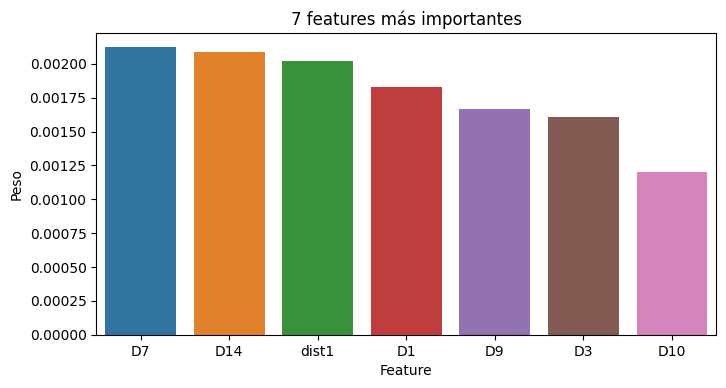

In [19]:
plt.subplots(dpi = 100, figsize = (8, 4))
ax = sns.barplot(data = features.nlargest(7, "abs"), x = "index", y = "abs", order = features.nlargest(7, "abs")["index"])
ax.set(xlabel = "Feature", ylabel = "Peso", title = "7 features más importantes",
       xticklabels = [dfTest.columns[int(label.get_text())] for label in ax.get_xticklabels()])

Las 7 _features_ más importantes según el modelo obtenido fueron (en orden decreciente): _D7_, _D14_, _dist1_, _D1_, _D9_, _D3_, _D10_